# Convolutional Neural Networks (CNNs)

### Welcome to the 10th Lab of 42028: Deep Learning and CNN!

In this  Lab/Tutorial session you will be implementing Inception module and create a Convolutional Neural Network for image classification .

So lets get started!

## Tutorial:
Implementation of Inception based Micro-GoogleNet CNN architecture using Keras for classfication of Cifar-10 dataset.

## Tasks for this week:

1. Implementation of Inception based Mini-GoogleNet CNN architecture for Cifar-10 classification using Keras API. 
2. Train and test model


**Reference and adapted from:** [https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/](https://www.analyticsvidhya.com/blog/2018/10/understanding-inception-network-from-scratch/)

## The Inception Begins !

### Step 1: Import required packages

we will need tensorflow, numpy, os and keras


In [1]:
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf

from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


### Step-2: Design the Inception V1 module

<img src='http://drive.google.com/uc?export=view&id=12vu9O4-f-jeuQIWg6nwAUFiZV8qwKM9j' alt='Conv'>




In [0]:
# Create the Inception module
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    # 1X1 CONV
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    # 1X1 CONV --> 3x3 CONV
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    # 1X1 CONV --> 5x5 CONV
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    # 3X3 MAXPOOL --> 1X1 CONV
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    # Concatenate the layers
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [0]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

### Step 3: Design a Micro-GoogleNet with 1 Layer of Inception V1

<img src='http://drive.google.com/uc?export=view&id=143ci2dp1TKZb6o9fXXR3122ewmXcxreL' alt='Conv'>



In [0]:
# Create the input layer
input_layer = Input(shape=(32, 32, 3)) # Use the actual input size

# CONV Layer
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_3x3/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)

#Adding Inception layer to te modeel
x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

In [0]:
# Form the model
model = Model(input_layer, x, name='inception_v1')

In [6]:
#Display Model Summary
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1_3x3/2 (Conv2D)           (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 32, 32, 64)   0           conv_1_3x3/2[0][0]               
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 96)   6240        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

### Step 4: Download the Cifar-10 dataset using keras

In [0]:
num_classes = 10 #Number of classes in the dataset

def load_cifar10_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()
    
    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid

In [8]:
# Display the shapes of the training images
X_train, y_train, X_test, y_test = load_cifar10_data(32, 32)
print(X_train.shape)
print(X_test.shape)

170500096/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


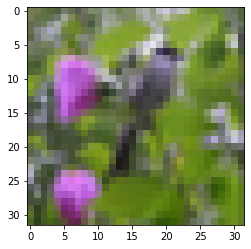

In [9]:
## Display an image from the dataset
import matplotlib.pyplot as plt
plt.imshow(X_train[300])

### Step 5: Define the Hyper-parameters, Compile the model, Start training

In [0]:
#Define the number of epochs and learning rate
epochs = 25
initial_lrate = 0.01

#Create Learning rate decay
def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#Define SGD paramenters
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

## Compile Model
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [11]:
#Start training the model
history1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=256, callbacks=[lr_sc])

Train on 50000 samples, validate on 10000 samples
Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 17s 349us/step - loss: 2.2155 - accuracy: 0.1659 - val_loss: 2.0774 - val_accuracy: 0.2227
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 11s 212us/step - loss: 2.0622 - accuracy: 0.2197 - val_loss: 1.9956 - val_accuracy: 0.2496
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 11s 214us/step - loss: 1.9891 - accuracy: 0.2493 - val_loss: 1.9208 - val_accuracy: 0.2784
Epoch 4/25

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 11s 214us/step - loss: 1.9097 - accuracy: 0.2742 - val_loss: 1.8335 - val_accuracy: 0.3162
Epoch 5/25

Epoch 00005: LearningRateScheduler setting learning rate to 0.01.
50000/50

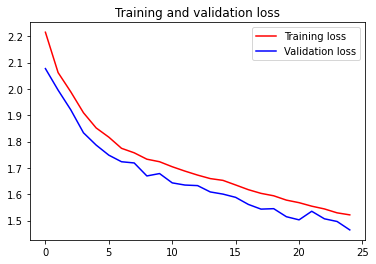

In [12]:
## Plot the Traning and Validation loss
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Your task begins now!

## Task 1: Design a Mini-GoogleNet with Inception V1 model

### Add four inception layers in the Micro-GoogleNet architecture created above in the following order and configuration:

<img src='http://drive.google.com/uc?export=view&id=1674k5lS1gTnT7-YaqhoKEDQadttsJMcl' alt='Conv'>


In [0]:
# Define the input layer
input_layer = Input(shape=(32, 32, 3))

# Add the first CONV layer and MaxPOOL layer
x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_3x3/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)

## Add Inception layer-1
x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

## Add Inception layer-2
x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

## Add MaxPool
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

## Add Inception layer-3
x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')

## Add Inception layer-4
x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(10, activation='softmax', name='output')(x)

In [0]:
# Form the Model
model = Model(input_layer, x, name='inception_v1')

In [15]:
# Print Model Summary
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1_3x3/2 (Conv2D)           (None, 32, 32, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 32, 32, 64)   0           conv_1_3x3/2[0][0]               
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 96)   6240        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

## Task 2: Define the HyperParamenters, Optimzer, etc

In [0]:
#Define the number of epochs and learning rate
epochs = 25
initial_lrate = 0.01

#Create Learning rate decay
def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

#Define SGD paramenters
sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

## Task 3: Compile and Train the Model

In [17]:
# Compile the model and start training
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=256, callbacks=[lr_sc])

Train on 50000 samples, validate on 10000 samples
Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 46s 919us/step - loss: 2.1574 - accuracy: 0.1819 - val_loss: 1.9646 - val_accuracy: 0.2489
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 44s 873us/step - loss: 1.9184 - accuracy: 0.2689 - val_loss: 1.8874 - val_accuracy: 0.2720
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 44s 873us/step - loss: 1.8012 - accuracy: 0.3179 - val_loss: 1.7007 - val_accuracy: 0.3717
Epoch 4/25

Epoch 00004: LearningRateScheduler setting learning rate to 0.01.
50000/50000 [==============================] - 44s 873us/step - loss: 1.7110 - accuracy: 0.3639 - val_loss: 1.6817 - val_accuracy: 0.3786
Epoch 5/25

Epoch 00005: LearningRateScheduler setting learning rate to 0.01.
50000/50

## Task 4: Test on Train and Test set

In [18]:
# Test the model on Test and Validationa dataset
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 4s 397us/step


[0.7961762735366821, 0.7200999855995178]

## Task 5: Display the Train and Validation Loss curve

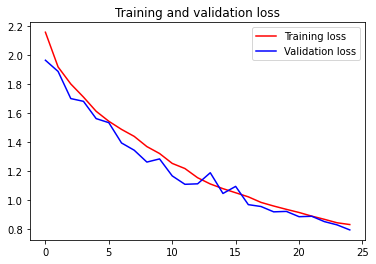

In [19]:
# Display the train and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()